In [2]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
import opensmile
import audiofile

In [3]:
# Constants
BASE_PATH = '/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC Dataset/'

# Mappings from codes to descriptions
emotion_codes = {'01': 'Angry', '02': 'Happy', '03': 'Sad', '04': 'Surprise'}
sentence_codes = {'01': '১২ টা বেজে গেছে', '02': 'আমি জানতাম এমন কিছু হবে', '03': 'এ কেমন উপহার'}
repetition_codes = {'01': '1st Repetition', '02': '2nd Repetition', '03': '3rd Repetition'}
actor_gender = lambda x: 'Male' if int(x) % 2 != 0 else 'Female'

# Variables to store extracted data
files_info = []

# Process each file in the dataset directory
for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".wav"):
            parts = file.split('-')
            emotion = emotion_codes.get(parts[2], 'Unknown')
            sentence = sentence_codes.get(parts[4], 'Unknown')
            repetition = repetition_codes.get(parts[5], 'Unknown')
            actor_id = parts[6].split('.')[0]
            gender = actor_gender(actor_id)
            files_info.append([
                emotion, sentence, repetition, actor_id, gender, os.path.join(root, file)
            ])

# Create a DataFrame from the structured data
df = pd.DataFrame(files_info, columns=[
    'Emotion', 'Sentence', 'Repetition', 'ActorID', 'Gender', 'Path'
])
df.sort_values(by=['ActorID', 'Emotion', 'Repetition'])

,Emotion,Sentence,Repetition,ActorID,Gender,Path
694,Angry,এ কেমন উপহার,1st Repetition,01,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...
696,Angry,১২ টা বেজে গেছে,1st Repetition,01,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...
704,Angry,আমি জানতাম এমন কিছু হবে,1st Repetition,01,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...
685,Angry,১২ টা বেজে গেছে,2nd Repetition,01,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...
714,Angry,আমি জানতাম এমন কিছু হবে,2nd Repetition,01,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...
...,...,...,...,...,...,...
162,Surprise,আমি জানতাম এমন কিছু হবে,2nd Repetition,34,Female,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...
167,Surprise,১২ টা বেজে গেছে,2nd Repetition,34,Female,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...
150,Surprise,আমি জানতাম এমন কিছু হবে,3rd Repetition,34,Female,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...
151,Surprise,১২ টা বেজে গেছে,3rd Repetition,34,Female,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...


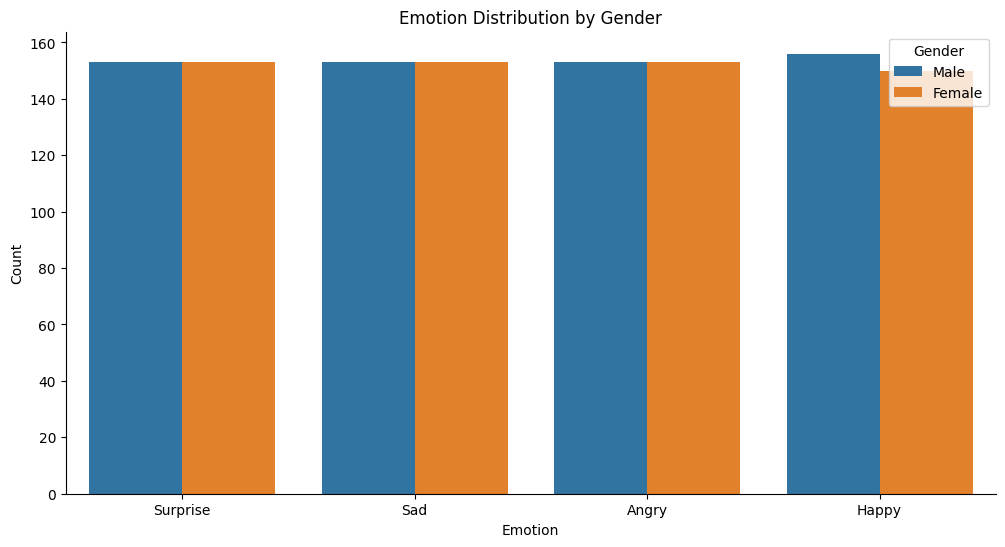

In [4]:
# Visualization: Emotion Distribution by Gender
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Emotion', hue='Gender')
plt.title('Emotion Distribution by Gender')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.legend(title='Gender')
sns.despine()
plt.show()

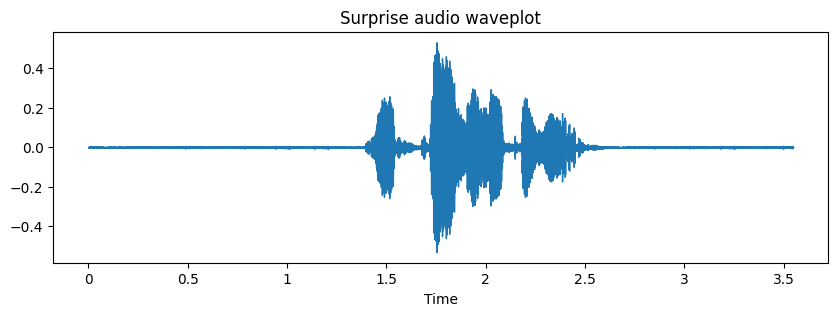

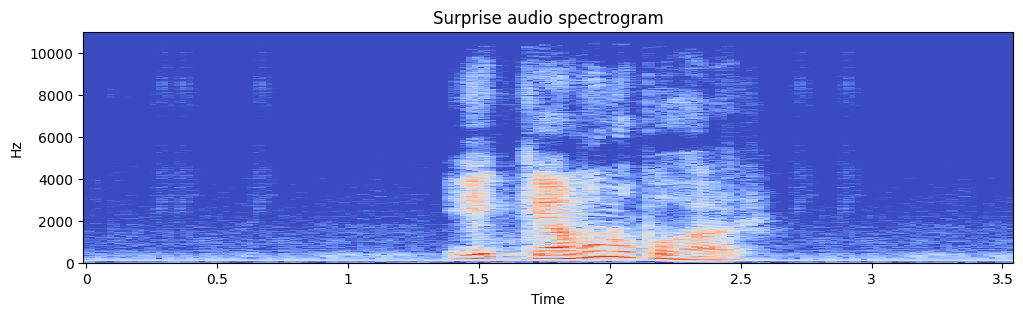

In [5]:
# Audio analysis functions
def waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f"{e} audio waveplot")
    librosa.display.waveshow(data, sr=sr)

def spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f"{e} audio spectrogram")
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
# Sample Audio Processing
path = df.iloc[0]["Path"]
emotion = df.iloc[0]["Emotion"]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

In [6]:
# Opensmile feature extraction adapted for EMODB
class openSmileExtractor():
    def __init__(self, featureLevel=opensmile.FeatureLevel.Functionals):
        self.smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.eGeMAPSv02,
            feature_level=featureLevel,
        )
    
    def processSignal(self, path):
        signal, sampling_rate = audiofile.read(path, always_2d=True)
        process = self.smile.process_signal(signal, sampling_rate)
        return process
    
    def processSignals(self, paths):
        features = pd.DataFrame()
        for path in paths:
            if paths.index(path) % 10 == 0:
                print('On {}% of {}'.format(round(paths.index(path) / len(paths) * 100, 3), len(paths)))
            feature = self.processSignal(path)
            feature['Path'] = path  # Add the path for merging
            features = pd.concat([features, feature], ignore_index=True)
        return features
    
    def processDF(self, df, filename="opensmileDF_beasc.csv"):
        paths = list(df["Path"])
        feature_df = self.processSignals(paths)
        final_df = pd.merge(df, feature_df, how="left", on=["Path"])
        final_df.to_csv(filename)
        return final_df

extractor = openSmileExtractor(featureLevel=opensmile.FeatureLevel.Functionals)
res = extractor.processDF(df, filename="/kaggle/working/opensmileDF_beasc.csv")
res

On 0.0% of 1224
On 0.817% of 1224
On 1.634% of 1224
On 2.451% of 1224
On 3.268% of 1224
On 4.085% of 1224
On 4.902% of 1224
On 5.719% of 1224
On 6.536% of 1224
On 7.353% of 1224
On 8.17% of 1224
On 8.987% of 1224
On 9.804% of 1224
On 10.621% of 1224
On 11.438% of 1224
On 12.255% of 1224
On 13.072% of 1224
On 13.889% of 1224
On 14.706% of 1224
On 15.523% of 1224
On 16.34% of 1224
On 17.157% of 1224
On 17.974% of 1224
On 18.791% of 1224
On 19.608% of 1224
On 20.425% of 1224
On 21.242% of 1224
On 22.059% of 1224
On 22.876% of 1224
On 23.693% of 1224
On 24.51% of 1224
On 25.327% of 1224
On 26.144% of 1224
On 26.961% of 1224
On 27.778% of 1224
On 28.595% of 1224
On 29.412% of 1224
On 30.229% of 1224
On 31.046% of 1224
On 31.863% of 1224
On 32.68% of 1224
On 33.497% of 1224
On 34.314% of 1224
On 35.131% of 1224
On 35.948% of 1224
On 36.765% of 1224
On 37.582% of 1224
On 38.399% of 1224
On 39.216% of 1224
On 40.033% of 1224
On 40.85% of 1224
On 41.667% of 1224
On 42.484% of 1224
On 43.301% of

,Emotion,Sentence,Repetition,ActorID,Gender,Path,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,Surprise,এ কেমন উপহার,3rd Repetition,13,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...,28.801308,0.237674,22.078192,29.800087,...,0.013212,-0.000054,0.073681,1.416431,4.322766,0.103333,0.108053,0.120000,0.113883,-26.695810
1,Sad,এ কেমন উপহার,1st Repetition,13,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...,29.708330,0.212820,22.949135,30.356445,...,0.023539,0.004622,0.015338,0.890208,0.604230,0.510000,0.320000,0.746667,0.591965,-18.034834
2,Angry,১২ টা বেজে গেছে,1st Repetition,13,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...,31.384871,0.197613,28.509445,31.196419,...,0.086390,0.016341,0.062598,3.053435,0.778210,0.630000,0.060000,0.625000,0.145000,-19.425911
3,Sad,আমি জানতাম এমন কিছু হবে,1st Repetition,13,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...,24.245302,0.201603,21.443314,22.433372,...,0.032436,0.000911,0.237372,1.388889,1.983003,0.408571,0.375516,0.102000,0.107406,-21.092005
4,Angry,১২ টা বেজে গেছে,3rd Repetition,13,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...,30.205219,0.097247,28.252817,31.403254,...,-0.016499,-0.001244,0.092483,2.621723,0.763359,0.675000,0.095000,0.406667,0.316263,-20.275412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,Happy,আমি জানতাম এমন কিছু হবে,2nd Repetition,03,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...,29.077822,0.215824,28.124344,29.784267,...,0.125071,-0.003541,0.020288,2.406417,0.813008,0.606667,0.514868,0.596667,0.454190,-26.132046
1220,Happy,এ কেমন উপহার,2nd Repetition,03,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...,31.004829,0.190075,28.259293,32.812851,...,0.119128,-0.004953,0.005038,1.432665,0.872093,0.360000,0.355059,0.760000,0.530911,-27.106577
1221,Happy,এ কেমন উপহার,1st Repetition,03,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...,28.926882,0.138169,26.389791,30.169842,...,0.118891,-0.006486,0.006601,1.146132,0.872093,0.376667,0.395418,0.743333,0.489376,-28.451828
1222,Angry,আমি জানতাম এমন কিছু হবে,2nd Repetition,03,Male,/kaggle/input/beasc-dataset/t9h6p943xy-2/BEASC...,30.069513,0.121124,27.740967,31.109415,...,0.117742,-0.004226,0.014770,2.472528,0.557103,0.845000,0.335000,0.603333,0.395418,-19.886396
